In [1]:
from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import wrf
import cartopy
import cartopy.crs as ccrs
from metpy.plots import USCOUNTIES
import pandas as pd
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

mpl.rcParams['font.size'] = 12

In [2]:
from netCDF4 import Dataset
wrfout = Dataset('/data/keeling/a/jcurtis2/d/bridges2_big_run/aerosols_d01_2010-06-17_00:00:00', "r", format="NETCDF4")
wrfinput = Dataset('/data/keeling/a/jcurtis2/d/bridges2_big_run/wrfinput_d01', "r", format="NETCDF4")
ozone = wrf.getvar(wrfout, "o3")
lats, lons = wrf.latlon_coords(ozone)
lats = wrf.to_np(lats)
lons = wrf.to_np(lons)
land_mask = wrfinput['LANDMASK'][0,:,:].T
land_mask[land_mask == 0] = np.NaN

In [3]:
def nc_shape(var):
    da = xr.DataArray(
        data=var.T,
        dims=["south_north", "west_east"],
        coords=dict(
            lon=(["south_north", "west_east"], lons),
            lat=(["south_north", "west_east"], lats),
        ),
        attrs=dict(
            description="var",
            units="1",
        ),
    )
    return da

In [4]:
# To load the colormap from the JSON file and recreate it
import json
from matplotlib.colors import ListedColormap
with open('/data/keeling/a/xx24/colormap.json', 'r') as json_file:
    loaded_colors = json.load(json_file)
    loaded_colors = [(r / 255, g / 255, b / 255) for r, g, b in loaded_colors]
    cmap = ListedColormap(loaded_colors)

In [5]:
def make_single_map(var, vmin, vmax,label,scale):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3),
                            subplot_kw=dict(projection=ccrs.PlateCarree()), 
                            gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
    fig.subplots_adjust(right=0.9)  # Adjust the right margin for the colorbar

    var_map = nc_shape(var)
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()])
    ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='grey', linewidth=0.5)

    states_provinces = cartopy.feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    ax.add_feature(states_provinces, edgecolor='black')
    ax.coastlines(resolution='50m', color='black', linewidth=1)

    if scale == 'log':
        im = ax.pcolormesh(lons, lats, var_map[:, :], norm = colors.LogNorm(vmin=vmin, vmax=vmax),  transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', edgecolor='face', antialiased=False)                    
    else:
        im = ax.pcolormesh(lons, lats, var_map[:, :], vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', edgecolor='face', antialiased=False)

    position = fig.add_axes([0.92, 0.2, 0.05, 0.59])  # [left, bottom, width, height]
    cbar = plt.colorbar(im, ax=ax, cax=position)
    cbar.set_label(label)

    # plt.savefig('xxx.pdf', bbox_inches='tight')

In [6]:
def make_map(var_all, var_small, var_large, vmin, vmax,label,scale):
    var_list = [var_all, var_small, var_large]
    title = ['All',r'$D<100~\mathrm{nm}$',r'$D>100~\mathrm{nm}$']

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 4),
                            subplot_kw=dict(projection=ccrs.PlateCarree()), 
                            gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
    fig.subplots_adjust(right=0.9)  # Adjust the right margin for the colorbar

    for i, ax in enumerate(axs.flat):
        var_map = nc_shape(var_list[i])
        ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()])
        ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='grey', linewidth=0.5)

        states_provinces = cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')

        ax.add_feature(states_provinces, edgecolor='black')
        ax.coastlines(resolution='50m', color='black', linewidth=1)
    
        var = var_list[i]
        if scale == 'log':
            im = ax.pcolormesh(lons, lats, var_map[:, :], norm = colors.LogNorm(vmin=vmin, vmax=vmax),  transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', edgecolor='face', antialiased=False)                    
        else:
            im = ax.pcolormesh(lons, lats, var_map[:, :], vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', edgecolor='face', antialiased=False)
        ax.set_title(title[i])

        position = fig.add_axes([0.92, 0.28, 0.02, 0.45])  # [left, bottom, width, height]
        cbar = plt.colorbar(im, ax=axs, cax=position)
        cbar.set_label(label)

    # plt.savefig('xxx.pdf', bbox_inches='tight')

In [7]:
fp = '/data/keeling/a/xx24/d/proj_film/poa_soa/'

In [8]:
# OC
oc_mf_all = pd.read_csv(f'{fp}/oc_mass_fracs_all.csv', sep=',', header=None)
oc_mf_all_1km = pd.read_csv(f'{fp}/oc_mass_fracs_all_1km.csv', sep=',', header=None)
oc_mf_small = pd.read_csv(f'{fp}/oc_mass_fracs_small.csv', sep=',', header=None)
oc_mf_small_1km = pd.read_csv(f'{fp}/oc_mass_fracs_small_1km.csv', sep=',', header=None)
oc_mf_large = pd.read_csv(f'{fp}/oc_mass_fracs_large.csv', sep=',', header=None)
oc_mf_large_1km = pd.read_csv(f'{fp}/oc_mass_fracs_large_1km.csv', sep=',', header=None)

# SOA
soa_mf_all = pd.read_csv(f'{fp}/soa_mass_fracs_all.csv', sep=',', header=None)
soa_mf_all_1km = pd.read_csv(f'{fp}/soa_mass_fracs_all_1km.csv', sep=',', header=None)
soa_mf_small = pd.read_csv(f'{fp}/soa_mass_fracs_small.csv', sep=',', header=None)
soa_mf_small_1km = pd.read_csv(f'{fp}/soa_mass_fracs_small_1km.csv', sep=',', header=None)
soa_mf_large = pd.read_csv(f'{fp}/soa_mass_fracs_large.csv', sep=',', header=None)
soa_mf_large_1km = pd.read_csv(f'{fp}/soa_mass_fracs_large_1km.csv', sep=',', header=None)

# OA
oa_mf_all = (oc_mf_all + soa_mf_all) 
oa_mf_all_1km = (oc_mf_all_1km + soa_mf_all_1km) 
oa_mf_large = (oc_mf_large + soa_mf_large)
oa_mf_large_1km = (oc_mf_large_1km + soa_mf_large_1km)
oa_mf_small = (oc_mf_small + soa_mf_small)
oa_mf_small_1km = (oc_mf_small_1km + soa_mf_small_1km)

# OA

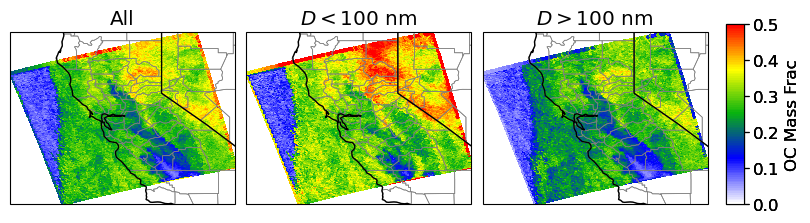

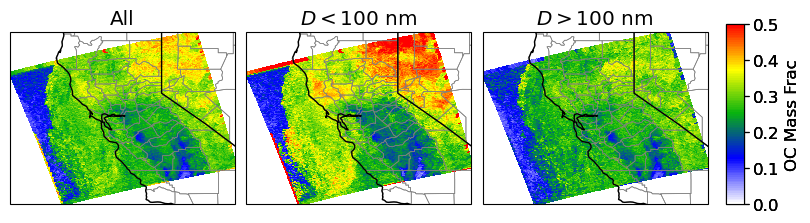

In [9]:
make_map(oa_mf_all, oa_mf_small, oa_mf_large, 0, 0.5, r'OC Mass Frac', 'linear')
make_map(oa_mf_all_1km, oa_mf_small_1km, oa_mf_large_1km, 0, 0.5, r'OC Mass Frac', 'linear')

/tmp/ipykernel_192183/306296704.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


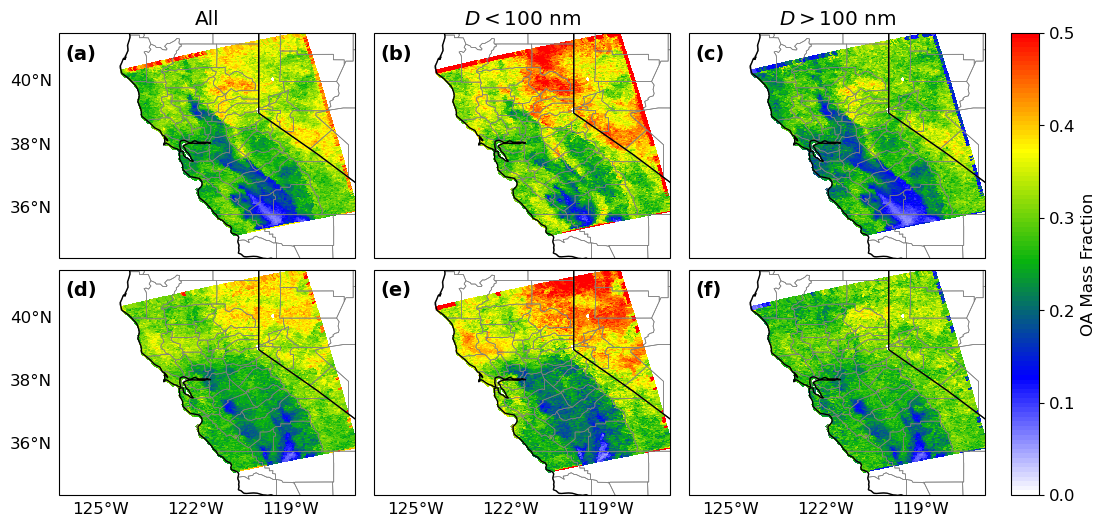

In [10]:
var_list = [oa_mf_all, oa_mf_small, oa_mf_large,
            oa_mf_all_1km, oa_mf_small_1km, oa_mf_large_1km]
title = ['All',r'$D<100~\mathrm{nm}$',r'$D>100~\mathrm{nm}$']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6),
                        subplot_kw=dict(projection=ccrs.PlateCarree()), 
                        gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
fig.subplots_adjust(right=0.9)  # Adjust the right margin for the colorbar

# Add text labels to each subplot
labels = [f'({chr(97+i)})' for i in range(6)]  # Generate labels (a), (b), ...
for ax, label in zip(axs.flat, labels):
    ax.annotate(label, xy=(0.02, 0.95), xycoords='axes fraction', fontsize=14, fontweight='bold',
                horizontalalignment='left', verticalalignment='top')

for i, ax in enumerate(axs.flat):
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()])
    ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='grey', linewidth=0.5)

    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    ax.add_feature(states_provinces, edgecolor='black')
    ax.coastlines(resolution='50m', color='black', linewidth=1)

    
    var = nc_shape(var_list[i]*land_mask)
    im = ax.pcolormesh(lons, lats, var[:, :], vmin=0, vmax=0.5, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', edgecolor='face', antialiased=False)                           

    if i == 2:
        position = fig.add_axes([0.92, 0.11, 0.023, 0.77])  # [left, bottom, width, height]
        cbar = plt.colorbar(im, ax=axs, cax=position)
        cbar.set_label(r"OA Mass Fraction")

    if i < 3:
        ax.set_title(title[i])

    # Add gridlines with labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='none')  # No grid lines
    
    # Customize longitude labels
    gl.xlocator = mticker.FixedLocator(range(-125, -116, 3))
    
    # Customize latitude labels
    gl.ylocator = mticker.FixedLocator(range(int(lats.min()), int(lats.max()), 2))  
    
    # Only show latitude labels on the left two subplots
    if i % 3 == 0:  # Left subplots
        gl.left_labels = True
    else:
        gl.left_labels = False
    
    # Only show longitude labels on the bottom two subplots
    if i > 2:  # Bottom subplots
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False
    
    gl.top_labels = False
    gl.right_labels = False

plt.tight_layout()
plt.savefig('/data/keeling/a/xx24/d/proj_film/oa_mass_frac_surface_and_1km.pdf', bbox_inches='tight')
plt.show()